# XGBoost
Training auf IDS17 80%  
Validierung auf IDS17 10%   
Test auf IDS17 10%

In [3]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import joblib

In [4]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
parquet_verzeichnis_ids17 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet'
parquet_verzeichnis_ids18 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet'

### Laden von IDS17

In [5]:
# IDS17 Datensatz einlesen für Training 80%, Validierung 10% und Test 10%
ids17 = pd.read_parquet(os.path.join(parquet_verzeichnis_ids17 + '_prep_0'))
print("Class distribution\n{}".format(ids17.Label.value_counts()))

Class distribution
Label
BENIGN                          1582561
DoS Hulk                         158468
DDoS-LOIC-HTTP                    95144
Infiltration - NMAP Portscan      71767
DoS GoldenEye                      7567
DoS Slowloris                      3859
SSH-BruteForce                     2961
Botnet Ares                         736
Web Attack - Brute Force             73
Web Attack - XSS                     18
Web Attack - SQL                     13
Name: count, dtype: int64


In [6]:
print(ids17.shape)
print(ids17.columns)

(1923167, 84)
Index(['Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
       'Total Bwd packets', 'Total Length of Fwd Packet',
       'Total Length of Bwd Packet', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Vari

### Trennen von Features und Labels

In [7]:
X = ids17.iloc[:, :-1]  # Alle Spalten außer der letzten
print(f"Form von X: {X.shape}")
y = ids17.iloc[:, -1]   # Die letzte Spalte
print(f"Form von y: {y.shape}")

Form von X: (1923167, 83)
Form von y: (1923167,)


### Label Encoding für y

In [8]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Einzigartige Labels: {label_encoder.classes_}")
print(f"Kodierte Labels: {np.unique(y_encoded)}")

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce'
 'Web Attack - Brute Force' 'Web Attack - SQL' 'Web Attack - XSS']
Kodierte Labels: [ 0  1  2  3  4  5  6  7  8  9 10]


### Skallierung von X

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Form von X: {X.shape}")
print(f"Form von X_scaled: {X_scaled.shape}")

Form von X: (1923167, 83)
Form von X_scaled: (1923167, 83)


### Aufteilen der Daten in Trainings-, Validierungs- und Testdatensätze

In [10]:
# Aufteilen in Trainings- und temporären Datensatz
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded)

# Aufteilen des temporären Datensatzes in Validierung und Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print(f"Form von X_train: {X_train.shape}")
print(f"Form von X_val: {X_val.shape}")
print(f"Form von X_test: {X_test.shape}")

Form von X_train: (1538533, 83)
Form von X_val: (192317, 83)
Form von X_test: (192317, 83)


### Überprüfen der Klassenverteilung

In [11]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_train, "Trainingsdatensatz")
print_class_distribution(y_val, "Validierungsdatensatz")
print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Trainingsdatensatz:
  Klasse 0: 1266048 Beispiele (82.29%)
  Klasse 1: 589 Beispiele (0.04%)
  Klasse 2: 76115 Beispiele (4.95%)
  Klasse 3: 6054 Beispiele (0.39%)
  Klasse 4: 126774 Beispiele (8.24%)
  Klasse 5: 3087 Beispiele (0.20%)
  Klasse 6: 57414 Beispiele (3.73%)
  Klasse 7: 2369 Beispiele (0.15%)
  Klasse 8: 58 Beispiele (0.00%)
  Klasse 9: 11 Beispiele (0.00%)
  Klasse 10: 14 Beispiele (0.00%)

Klassenverteilung in Validierungsdatensatz:
  Klasse 0: 158257 Beispiele (82.29%)
  Klasse 1: 74 Beispiele (0.04%)
  Klasse 2: 9514 Beispiele (4.95%)
  Klasse 3: 756 Beispiele (0.39%)
  Klasse 4: 15847 Beispiele (8.24%)
  Klasse 5: 386 Beispiele (0.20%)
  Klasse 6: 7176 Beispiele (3.73%)
  Klasse 7: 296 Beispiele (0.15%)
  Klasse 8: 8 Beispiele (0.00%)
  Klasse 9: 1 Beispiele (0.00%)
  Klasse 10: 2 Beispiele (0.00%)

Klassenverteilung in Testdatensatz:
  Klasse 0: 158256 Beispiele (82.29%)
  Klasse 1: 73 Beispiele (0.04%)
  Klasse 2: 9515 Beispiele (4.95%)
  Klasse

### Hyperparameter-Tuning mit dem Validierungsdatensatz

In [ ]:
param_grid = {
    'n_estimators': [100, 200],      # Anzahl der Bäume im Modell
    'max_depth': [3, 6, 10],         # Maximale Tiefe der Bäume
    'learning_rate': [0.01, 0.1, 0.2],  # Lernrate für den Boosting-Prozess
    'subsample': [0.8, 1.0]          # Prozentsatz der verwendeten Datenpunkte pro Baum
}


grid_search = GridSearchCV(XGBClassifier( 
    eval_metric='mlogloss', 
    random_state=42), 
    param_grid, 
    cv=2, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=10)


grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2; 4/36] START learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0
[CV 2/2; 1/36] START learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8
[CV 2/2; 9/36] START learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8
[CV 1/2; 1/36] START learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8
[CV 1/2; 11/36] START learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.8
[CV 2/2; 8/36] START learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0
[CV 2/2; 3/36] START learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8
[CV 1/2; 8/36] START learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0
[CV 2/2; 7/36] START learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8
[CV 2/2; 2/36] START learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0
[CV 2/2; 12/36] START learning_rate=0.01, max_depth=10, n_estimators=200, su

/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:51:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:51:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:51:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:51:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:51:09] WARNING: /workspa

[CV 1/2; 1/36] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.997 total time= 3.4min
[CV 1/2; 15/36] START learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8
[CV 1/2; 13/36] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=1.000 total time= 3.4min
[CV 2/2; 1/36] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.998 total time= 3.4min
[CV 2/2; 15/36] START learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8
[CV 1/2; 16/36] START learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0
[CV 2/2; 5/36] END learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8;, score=0.999 total time= 3.5min
[CV 2/2; 16/36] START learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0
[CV 1/2; 2/36] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.997 total time= 3.5min
[CV 1/2; 17/36] START learning_rate=0.1, max_depth=6, n_estimators=100,

/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:54:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:54:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:54:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:54:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/2; 2/36] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.997 total time= 3.7min
[CV 2/2; 17/36] START learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8
[CV 1/2; 10/36] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=1.0;, score=1.000 total time= 3.7min


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:54:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/2; 18/36] START learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0
[CV 1/2; 6/36] END learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0;, score=0.999 total time= 3.7min
[CV 2/2; 18/36] START learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:54:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:54:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:54:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/2; 10/36] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=1.0;, score=1.000 total time= 4.0min
[CV 1/2; 19/36] START learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:55:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/2; 14/36] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=1.000 total time= 4.1min
[CV 2/2; 19/36] START learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8
[CV 2/2; 6/36] END learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0;, score=0.999 total time= 4.2min
[CV 2/2; 14/36] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=1.000 total time= 4.2min
[CV 1/2; 20/36] START learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0
[CV 2/2; 20/36] START learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:55:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:55:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:55:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/2; 13/36] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=1.000 total time= 4.5min
[CV 1/2; 21/36] START learning_rate=0.1, max_depth=10, n_estimators=100, subsample=0.8
[CV 2/2; 9/36] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8;, score=1.000 total time= 4.5min
[CV 2/2; 21/36] START learning_rate=0.1, max_depth=10, n_estimators=100, subsample=0.8
[CV 1/2; 5/36] END learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8;, score=0.999 total time= 4.6min


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:55:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/2; 22/36] START learning_rate=0.1, max_depth=10, n_estimators=100, subsample=1.0


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:55:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/2; 9/36] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.8;, score=1.000 total time= 4.7min
[CV 2/2; 22/36] START learning_rate=0.1, max_depth=10, n_estimators=100, subsample=1.0


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:55:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:55:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/2; 4/36] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0;, score=0.998 total time= 5.9min
[CV 1/2; 23/36] START learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.8


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:56:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/2; 3/36] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=0.998 total time= 6.2min
[CV 2/2; 23/36] START learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.8


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:57:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/2; 4/36] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0;, score=0.998 total time= 6.4min
[CV 1/2; 24/36] START learning_rate=0.1, max_depth=10, n_estimators=200, subsample=1.0


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:57:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/2; 8/36] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0;, score=0.999 total time= 6.7min
[CV 2/2; 24/36] START learning_rate=0.1, max_depth=10, n_estimators=200, subsample=1.0


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:57:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/2; 18/36] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0;, score=1.000 total time= 3.2min
[CV 1/2; 25/36] START learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8
[CV 1/2; 8/36] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0;, score=0.999 total time= 7.0min
[CV 2/2; 17/36] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8;, score=1.000 total time= 3.3min
[CV 2/2; 25/36] START learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8
[CV 1/2; 26/36] START learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:57:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/2; 17/36] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8;, score=1.000 total time= 3.5min
[CV 2/2; 26/36] START learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:58:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:58:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:58:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/2; 18/36] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0;, score=1.000 total time= 3.6min
[CV 1/2; 27/36] START learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8
[CV 2/2; 3/36] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=0.998 total time= 7.4min


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:58:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/2; 27/36] START learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8
[CV 1/2; 12/36] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=1.0;, score=1.000 total time= 7.5min
[CV 1/2; 28/36] START learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:58:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:58:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/2; 7/36] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8;, score=0.999 total time= 7.8min
[CV 2/2; 28/36] START learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0
[CV 2/2; 21/36] END learning_rate=0.1, max_depth=10, n_estimators=100, subsample=0.8;, score=1.000 total time= 3.3min
[CV 1/2; 29/36] START learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8
[CV 2/2; 22/36] END learning_rate=0.1, max_depth=10, n_estimators=100, subsample=1.0;, score=1.000 total time= 3.2min
[CV 2/2; 29/36] START learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8
[CV 1/2; 7/36] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8;, score=0.999 total time= 7.9min


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:58:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:58:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/2; 30/36] START learning_rate=0.2, max_depth=6, n_estimators=100, subsample=1.0


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:58:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/2; 11/36] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.8;, score=1.000 total time= 8.1min


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:59:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/2; 30/36] START learning_rate=0.2, max_depth=6, n_estimators=100, subsample=1.0
[CV 1/2; 22/36] END learning_rate=0.1, max_depth=10, n_estimators=100, subsample=1.0;, score=1.000 total time= 3.6min
[CV 1/2; 31/36] START learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.8
[CV 1/2; 21/36] END learning_rate=0.1, max_depth=10, n_estimators=100, subsample=0.8;, score=1.000 total time= 3.8min
[CV 2/2; 31/36] START learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.8


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:59:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:59:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:59:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/2; 11/36] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.8;, score=1.000 total time= 8.6min
[CV 2/2; 12/36] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=1.0;, score=1.000 total time= 8.7min
[CV 1/2; 32/36] START learning_rate=0.2, max_depth=6, n_estimators=200, subsample=1.0
[CV 2/2; 32/36] START learning_rate=0.2, max_depth=6, n_estimators=200, subsample=1.0


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:59:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:59:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/2; 16/36] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0;, score=1.000 total time= 5.9min
[CV 1/2; 33/36] START learning_rate=0.2, max_depth=10, n_estimators=100, subsample=0.8


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:00:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/2; 26/36] END learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0;, score=1.000 total time= 3.1min
[CV 1/2; 25/36] END learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8;, score=1.000 total time= 3.3min
[CV 2/2; 33/36] START learning_rate=0.2, max_depth=10, n_estimators=100, subsample=0.8
[CV 1/2; 16/36] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0;, score=1.000 total time= 6.7min
[CV 1/2; 34/36] START learning_rate=0.2, max_depth=10, n_estimators=100, subsample=1.0
[CV 1/2; 15/36] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8;, score=1.000 total time= 6.9min
[CV 2/2; 34/36] START learning_rate=0.2, max_depth=10, n_estimators=100, subsample=1.0


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:01:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/2; 35/36] START learning_rate=0.2, max_depth=10, n_estimators=200, subsample=0.8


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:01:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:01:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/2; 19/36] END learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8;, score=1.000 total time= 6.2min
[CV 2/2; 26/36] END learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0;, score=1.000 total time= 3.4min
[CV 2/2; 35/36] START learning_rate=0.2, max_depth=10, n_estimators=200, subsample=0.8
[CV 1/2; 36/36] START learning_rate=0.2, max_depth=10, n_estimators=200, subsample=1.0


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:01:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:01:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:01:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/2; 25/36] END learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8;, score=1.000 total time= 3.7min
[CV 2/2; 36/36] START learning_rate=0.2, max_depth=10, n_estimators=200, subsample=1.0
[CV 2/2; 15/36] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8;, score=1.000 total time= 7.3min


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:01:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/2; 20/36] END learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0;, score=1.000 total time= 6.7min
[CV 1/2; 29/36] END learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8;, score=1.000 total time= 3.2min
[CV 2/2; 30/36] END learning_rate=0.2, max_depth=6, n_estimators=100, subsample=1.0;, score=1.000 total time= 3.0min
[CV 1/2; 20/36] END learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0;, score=1.000 total time= 7.0min
[CV 1/2; 30/36] END learning_rate=0.2, max_depth=6, n_estimators=100, subsample=1.0;, score=1.000 total time= 3.4min
[CV 1/2; 19/36] END learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8;, score=1.000 total time= 7.5min
[CV 2/2; 29/36] END learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8;, score=1.000 total time= 3.7min
[CV 1/2; 23/36] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.8;, score=1.000 total time= 6.2min
[CV 2/2; 23/36] END learning_rate=0.1, max_depth=10, n_estimato

/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:04:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 10], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=10)

 ### Bestes Modell auswählen

In [13]:
best_model = grid_search.best_estimator_
logging.info(f"Beste Hyperparameter: {grid_search.best_params_}")

2024-11-05 09:06:10 - INFO - Beste Hyperparameter: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


### Evaluierung auf dem Validierungsdatensatz

In [14]:
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)

print(f"Validierungs-Accuracy: {val_accuracy * 100:.2f}%")
print("\nValidierungs Classification Report:\n" + val_report)

Validierungs-Accuracy: 100.00%

Validierungs Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    158257
           1       1.00      1.00      1.00        74
           2       1.00      1.00      1.00      9514
           3       1.00      1.00      1.00       756
           4       1.00      1.00      1.00     15847
           5       1.00      1.00      1.00       386
           6       1.00      1.00      1.00      7176
           7       1.00      1.00      1.00       296
           8       1.00      1.00      1.00         8
           9       0.00      0.00      0.00         1
          10       1.00      1.00      1.00         2

    accuracy                           1.00    192317
   macro avg       0.91      0.91      0.91    192317
weighted avg       1.00      1.00      1.00    192317



/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Evaluierung des Modells auf dem Testdatensatz

In [15]:
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
logging.info(f"Test-Accuracy: {test_accuracy * 100:.2f}%")
logging.info("\nTest Classification Report:\n" + test_report)

2024-11-05 09:06:11 - INFO - Test-Accuracy: 100.00%
2024-11-05 09:06:11 - INFO - 
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    158256
           1       1.00      1.00      1.00        73
           2       1.00      1.00      1.00      9515
           3       1.00      1.00      1.00       757
           4       1.00      1.00      1.00     15847
           5       1.00      1.00      1.00       386
           6       1.00      1.00      1.00      7177
           7       1.00      1.00      1.00       296
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         1
          10       1.00      0.50      0.67         2

    accuracy                           1.00    192317
   macro avg       1.00      0.95      0.97    192317
weighted avg       1.00      1.00      1.00    192317



### Klassifikationsbericht und eine Konfusionsmatrix

In [17]:
# Klassifikationsbericht
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_test_pred)
print("Konfusionsmatrix:")
print(cm)

                              precision    recall  f1-score   support

                      BENIGN       1.00      1.00      1.00    158256
                 Botnet Ares       1.00      1.00      1.00        73
              DDoS-LOIC-HTTP       1.00      1.00      1.00      9515
               DoS GoldenEye       1.00      1.00      1.00       757
                    DoS Hulk       1.00      1.00      1.00     15847
               DoS Slowloris       1.00      1.00      1.00       386
Infiltration - NMAP Portscan       1.00      1.00      1.00      7177
              SSH-BruteForce       1.00      1.00      1.00       296
    Web Attack - Brute Force       1.00      1.00      1.00         7
            Web Attack - SQL       1.00      1.00      1.00         1
            Web Attack - XSS       1.00      0.50      0.67         2

                    accuracy                           1.00    192317
                   macro avg       1.00      0.95      0.97    192317
                we

Visualisierung der Konfusionsmatrix

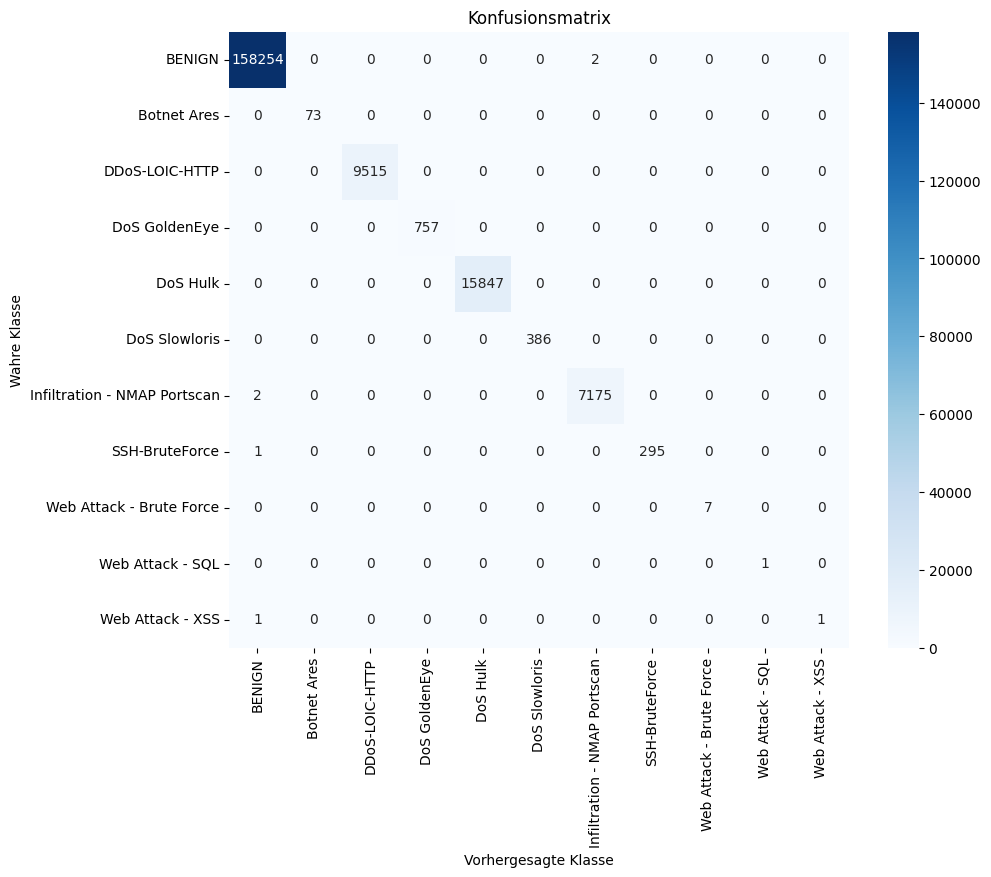

In [18]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()


### Speichern des Modells und der Vorverarbeitungsschritte

In [19]:
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(best_model, 'xgboost_model.pkl')

['xgboost_model.pkl']